In [145]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
%matplotlib inline

In [146]:
url = 'https://raw.githubusercontent.com/johnnymango/IS362stuff/master/nycdata.csv'
nycdata = pd.read_csv(url)
nycdata = nycdata.dropna()
nycdata.columns = ['zipcode', 'county', '2010pop', '2015pop', 'popchange', 'popsize', 'medAge', 'highed', 'medInc', 'povlevel']
nycdata.tail() 

,zipcode,county,2010pop,2015pop,popchange,popsize,medAge,highed,medInc,povlevel
314,11691,Queens,60035.0,63989.0,0.07,0.007,32.4,0.71,42023.0,0.23
315,11692,Queens,18540.0,18955.0,0.02,0.002,35.6,0.74,42127.0,0.22
316,11693,Queens,11916.0,11194.0,-0.06,0.001,40.6,0.83,53281.0,0.20
317,11694,Queens,20408.0,20773.0,0.02,0.002,45.1,0.88,75094.0,0.06
319,11697,Queens,4079.0,4006.0,-0.02,0.000,44.7,0.97,93333.0,0.04


In [147]:
nycdata.set_index('zipcode', inplace=True)
nycdata.head()

,county,2010pop,2015pop,popchange,popsize,medAge,highed,medInc,povlevel
zipcode,,,,,,,,,
10001,New York,21102.0,23537.0,0.12,0.003,35.6,0.92,86801.0,0.20
10002,New York,81410.0,80736.0,-0.01,0.009,40.8,0.68,33726.0,0.30
10003,New York,56024.0,57112.0,0.02,0.007,32.1,0.97,98151.0,0.10
10005,New York,7135.0,8131.0,0.14,0.001,29.4,0.99,124194.0,0.11
10009,New York,61347.0,60865.0,-0.01,0.007,37.0,0.85,59090.0,0.23


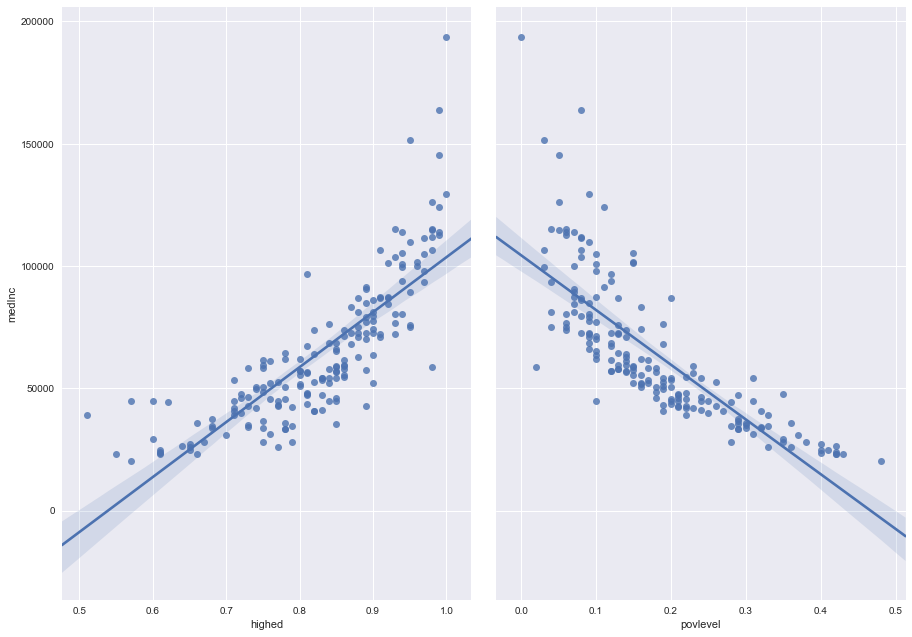

In [148]:
sns.pairplot(nycdata, x_vars=['highed', 'povlevel'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

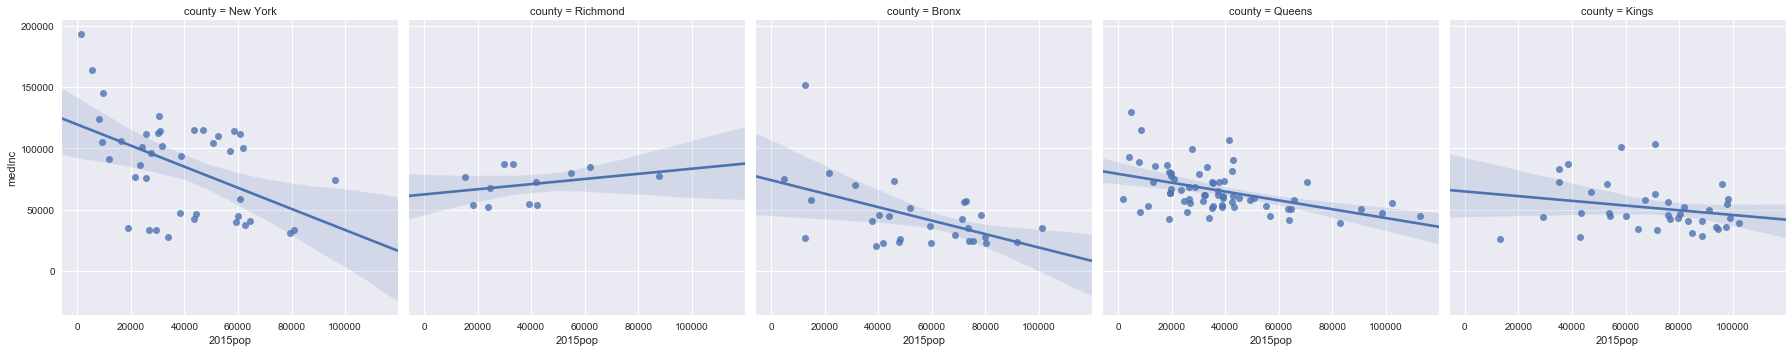

In [177]:
sns.lmplot(x='2015pop', y='medInc', col='county', data=nycdata)


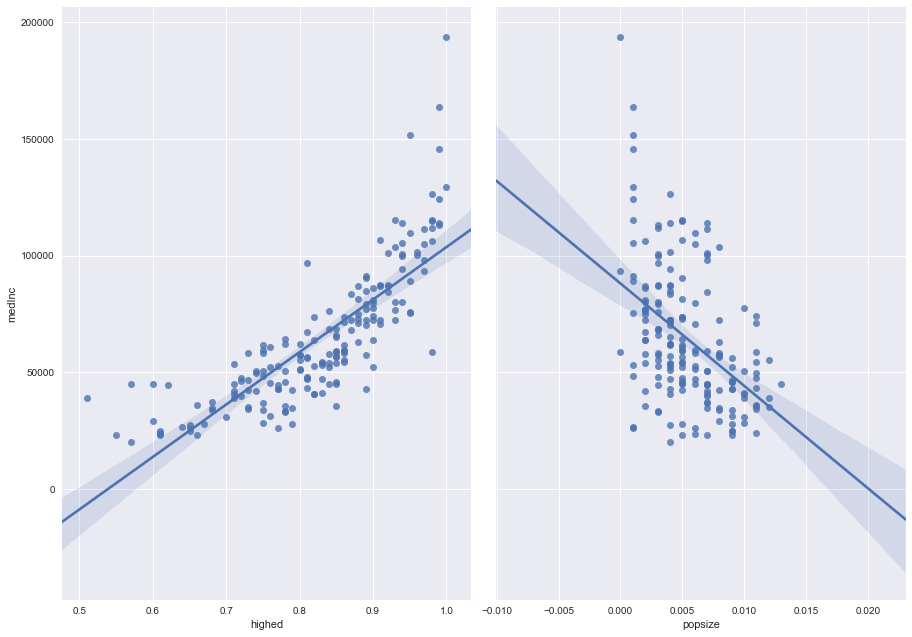

In [150]:
sns.pairplot(nycdata, x_vars=['highed', 'popsize'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

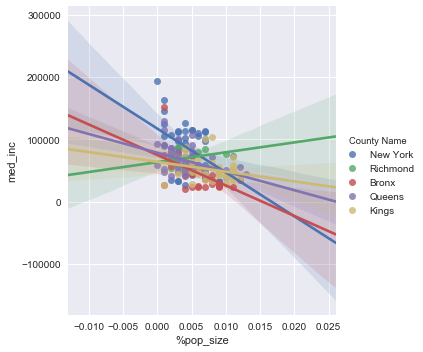

In [20]:
sns.lmplot(x='%pop_size', y='med_inc', hue='County Name', data=nycdata);

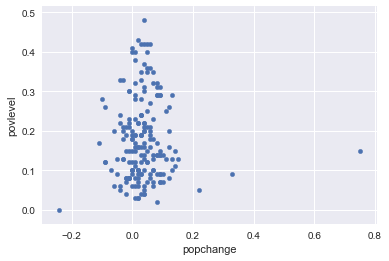

In [113]:
nyc_scatter = nycdata.plot.scatter(x='popchange', y='povlevel')
plt.show()

In [116]:
df = pymysql.connect(host='localhost',  
                       port=3306,  
                       user='root',  
                       passwd='jan2apr16',  
                       db='newyork',  
                       charset='utf8'
                    )
cur = df.cursor()

sql = """SELECT zip, cuisine, grade FROM nyc.restaurants"""
              
cur.execute(sql)
cur.close
df.close
restaurants = pd.read_sql(sql, df)
restaurants['grade'] = restaurants.grade.str.split('\r').str.get(0)
restaurants.columns =['zipcode', 'cuisine', 'grade']
restaurants.head()

,zipcode,cuisine,grade
0,11358,Korean,A
1,11205,Indian,A
2,10014,American,A
3,10018,CafÃ©/Coffee/Tea,A
4,11373,"Latin (Cuban, Dominican, Puerto Rican, South &...",A


In [153]:
restcounts = pd.DataFrame(restaurants['zipcode'].value_counts())
restcounts.columns = ['restcount']
restcounts.index.name = 'zipcode'

restcounts.head()

,restcount
zipcode,
10003,1506
10019,1319
10036,1242
10013,1097
10016,1069


In [158]:
type(nycdata.index)

pandas.indexes.numeric.Int64Index

In [159]:
type(restcounts.index)

pandas.indexes.base.Index

In [178]:
nycdata.index = nycdata.index.map(str)
restcounts.index = restcounts.index.map(str)
result = pd.concat([nycdata, restcounts], axis=1, join='inner')
result.head()

,county,2010pop,2015pop,popchange,popsize,medAge,highed,medInc,povlevel,restcount
10003,New York,56024.0,57112.0,0.02,0.007,32.1,0.97,98151.0,0.10,1506
10019,New York,42870.0,38830.0,-0.09,0.004,39.2,0.94,94022.0,0.12,1319
10036,New York,24711.0,25799.0,0.04,0.003,37.0,0.95,75966.0,0.13,1242
10013,New York,27700.0,27415.0,-0.01,0.003,36.9,0.81,96667.0,0.12,1097
10016,New York,54183.0,50641.0,-0.07,0.006,33.4,0.97,104826.0,0.10,1069


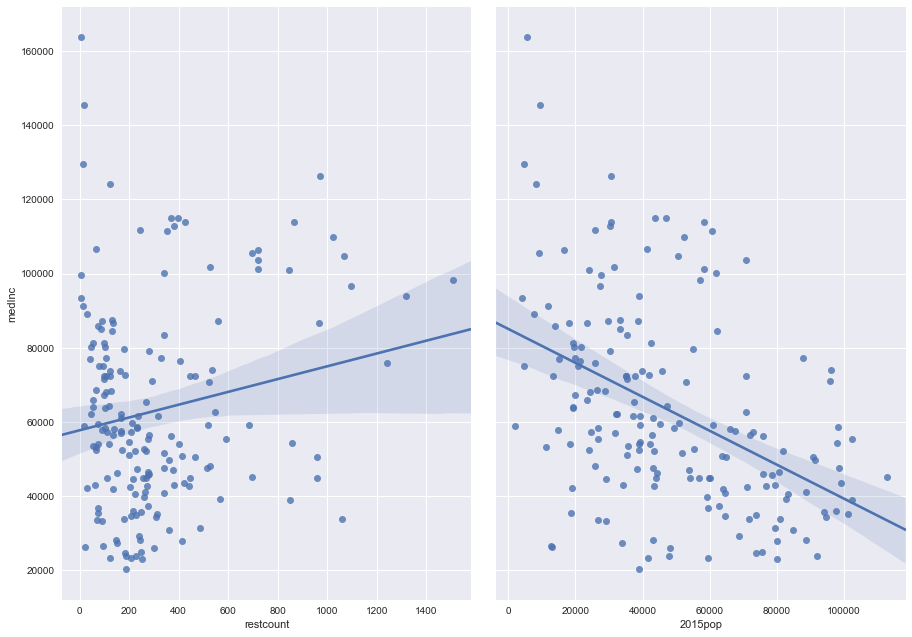

In [173]:
sns.pairplot(result, x_vars=['restcount', '2015pop'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

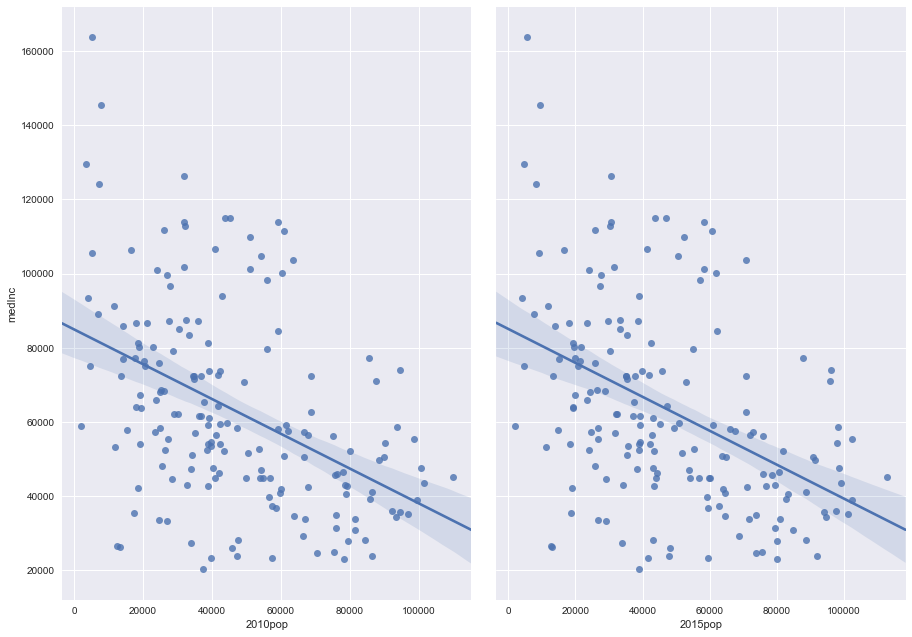

In [180]:
sns.pairplot(result, x_vars=['2010pop', '2015pop'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

In [100]:
cuisines = pd.DataFrame(restaurants['cuisine'].value_counts())
cuisines.columns = ['cuisinecounts']
cuisines.index.name = 'cuisinetype'
cuisines

,cuisinecounts
cuisinetype,
American,12086
Chinese,5816
"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",2774
Pizza,2449
Italian,2380
CafÃ©/Coffee/Tea,2163
Japanese,2079
Mexican,2013
Spanish,1681
